<a id="top"></a>
# UN SDG Indicator 11.3.1:<br> Ratio of Land Consumption Rate to Population Growth Rate


<hr>

# Notebook Summary
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 11.3.1 - ratio of land consumption rate to population growth rate.

UN SDG Indicator 11.3.1 provides a metric for determining wether or not land consumption is scaling responsibly with the growth of the  population in a given region.  

### Case Study

This notebook conducts analysis in the **Dar es Salaam, Tanzania** with reference years of `2000` and `2015`.

# Index

* [Define Formulas for Calculating the Indicator](#define_formulas)
* [Import Dependencies and Connect to the Data Cube](#import)
* [Show the Area](#show_area)
* [Determine Population Growth Rate](#pop_rate)
* [Determine Land Consumption Rate](#land_consumption_rate)
* [Build Composites for the First and Last Years](#false_color_composites)
* [Filter Out Everything Except the Survey Region](#filter_survey_region)
* [Determine Urban Extent](#urban_extent)
* [SDG Indicator 11.3.1](#indicator)

In [2]:
%matplotlib inline
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

## <a id="define_formulas"></a>Define Formulas for Calculating the Indicator [&#9652;](#top)


>### SDG Indicator 11.3.1
> The ratio between land consumption and population growth rate.   

$$ SDG_{11.1.3} = \frac{LandConsumptionRate}{PopulationGrowthRate} $$

def sdg_11_3_1(land_consumption, population_growth_rate): 
    return land_consumption/population_growth_rate


>### Population Growth rate

### $$ PopulationGrowthRate = 10 ^ {LOG( Pop_{t_2} \space / \space Pop_{t_1}) \space / \space {y}} - 1 $$
  
Where:  

- $Pop_{t_2}$ - Total population within the area in the current/final year
- $Pop_{t_1}$ - Total population within the area in the past/initial year  
- $y$   - The number of years between the two measurement periods $t = Year_{t_2} - Year_{t_1}$ 

import numpy as np  

def population_growth_rate(pop_t1 = None, pop_t2 = None, y = None): 
#     return np.log(pop_t2/pop_t1)/y
    return 10**(np.log10(pop_t2/pop_t1)/y) - 1


>### Land Consumption Rate


### $$ LandConsumptionRate = 10 ^ {LOG( Area_{t_2} \space / \space Area_{t_1}) \space / \space {y}} - 1 $$

Where:  

- $Area_{t_2}$ - Total area considered to be *urbanized* in the current/final year
- $Area_{t_1}$ - Total area considered to be *urbanized* in the past/initial year  
- $y$   - The number of years between the two measurement periods $t = Year_{t_2} - Year_{t_1}$ 

def land_consumption_rate(area_t1 = None, area_t2 = None, y = None):
#     return np.log(area_t2 / area_t1)/y
    return 10**(np.log10(area_t2/area_t1)/y) - 1

## <a id="import"></a>Import Dependencies and Connect to the Data Cube [&#9652;](#top)

# Supress Some Warnings
import warnings
warnings.filterwarnings('ignore')
# Allow importing of our utilities.
import sys
sys.path.append("..")
# Prepare for plotting.
import matplotlib.pyplot as plt
%matplotlib inline

import datacube
dc = datacube.Datacube()

## <a id="show_area"></a>Show the Area [&#9652;](#top)

# Dar es Salaam, Tanzania
latitude_extents =  (-6.95, -6.70) 
longitude_extents =  (39.05, 39.45)

from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extents, longitude = longitude_extents)

## <a id="pop_rate"></a>Determine Population Growth Rate [&#9652;](#top)

>### Load Population Data
<br>Shape files are based on GPW estimates. You can derive similar population figures from AidData GeoQuery at 
- http://geo.aiddata.org/query

CSV_FILE_PATH = "data/Tanzania/population_shape/ADM2_GPWV4_population.csv"
SHAPE_FILE_PATH = "data/Tanzania/population_shape/TZA_ADM2.geojson"

import geopandas as gpd
import pandas as pd

first_year, last_year = 2000, 2015
first_year_pop_col = 'gpw_v4_count.{}.sum'.format(first_year)
last_year_pop_col = 'gpw_v4_count.{}.sum'.format(last_year)

shape_data = gpd.read_file(SHAPE_FILE_PATH)
shape_data = shape_data[['Name', 'geometry']]
pop_data = pd.read_csv(CSV_FILE_PATH)
pop_data = pop_data[[first_year_pop_col, last_year_pop_col, 'Name']]
pop_data = pop_data.rename({first_year_pop_col: 'pop_t1', 
                            last_year_pop_col: 'pop_t2'}, axis='columns')
country_data = shape_data.merge(pop_data, on='Name')

def shapely_geom_intersects_rect(geom, x, y):
    """
    Determines whether the bounding box of a Shapely polygon intesects 
    a rectangle defined by `x` and `y` extents.
    
    Parameters
    ----------
    geom: shapely.geometry.polygon.Polygon
        The object to determine intersection with the region defined by `x` and `y`.
    x, y: list-like
        The x and y extents, expressed as 2-tuples.
        
    Returns
    -------
    intersects: bool
        Whether the bounding box of `geom` intersects the rectangle.
    """
    geom_bounds = np.array(list(geom.bounds))
    x_shp, y_shp = geom_bounds[[0,2]], geom_bounds[[1,3]]
    x_in_range = (x_shp[0] < x[1]) & (x[0] < x_shp[1])
    y_in_range = (y_shp[0] < y[1]) & (y[0] < y_shp[1])
    return x_in_range & y_in_range
    
intersecting_shapes = country_data[country_data.apply(
    lambda row: shapely_geom_intersects_rect(row.geometry, longitude_extents, latitude_extents), 
    axis=1).values]

**Show the Survey Region in the Context of the Country**

country_data.plot(column=country_data.Name.isin(intersecting_shapes['Name']), 
                                                    cmap='jet', figsize=(10,10))
survey_region = country_data[country_data.Name.isin(['Kinondoni', 'Ilala', 'Temeke'])]
plt.show()

**Show the Survey Region Alone**

survey_region.plot( figsize = (10,10))
plt.show()

**Determine the Shape that Masks the Survey Region**

from shapely.ops import cascaded_union
disjoint_areas = cascaded_union([*survey_region.geometry]) ## Top Right is 'disjoint' from bottom left.  

>### Calculate Population Growth Rate

**Calcuate Population Growth Rate for All Regions Individually**

country_data = country_data.assign(population_growth_rate = 
                                   np.log(country_data["pop_t2"]/country_data["pop_t1"])/10)

**Visualize Population Growth Rate**

fig, ax = plt.subplots(figsize  = (10, 10))
ax.set_title("Population Growth Rate {}-{}".format(first_year, last_year))
ax1 = country_data.plot(column = "population_growth_rate", ax = ax, legend=True)

survey_region_total_pop_t1 = survey_region["pop_t1"].sum()
survey_region_total_pop_t2 = survey_region["pop_t2"].sum()

time_range = last_year - first_year
pop_growth = population_growth_rate(pop_t1 = survey_region_total_pop_t1,
                                    pop_t2 = survey_region_total_pop_t2,
                                    y = time_range)

print("Population Growth Rate of the Survey Region: {:.2%}".format(pop_growth))


## <a id="land_consumption_rate"></a>Determine Land Consumption Rate [&#9652;](#top)

**Load Landsat Imagery**


product = "product = 'ls7_usgs_sr_scene'" 
platform = "LANDSAT_7"
measurements =  ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"]
#EPSG = "EPSG:4326"
EPSG = "EPSG:32760"

In [4]:
import datacube
import matplotlib.pyplot as plt
dc = datacube.Datacube(app = '3B_urban') 

In [5]:
output_projection = "EPSG:32760"
res = (30)
platform = 'LANDSAT_7'
product = 'ls7_usgs_sr_scene'
#set baseline start and end of period
#baseline_start_date = '2015-3-1'
#baseline_end_date = '2015-9-1'


# Determine the bounding box of the survey region to load data for.
min_lon, min_lat, max_lon, max_lat = disjoint_areas.bounds
lat = (min_lat, max_lat)
lon = (min_lon, max_lon)


In [6]:
from datacube_utilities.createAOI import create_lat_lon
#aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.5908487086))"
aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"
desired_bands = ['red','green','nir','swir1', 'swir2', 'pixel_qa']  # needed by ndvi, ndwi, ndbi and cloud masking
measurements = desired_bands + ['blue'] # blue is needed for a true color visualization purposes

lat, lon = create_lat_lon(aoi_wkt)
print("Lat:", lat, "\n"
      "Lon:", lon)

Lat: (-17.590848708679893, -17.488875828028657) 
Lon: (177.62557983398438, 177.77372360229492)


In [7]:
time_extents_t1 = ('2000-01-01', '2000-12-31')
time_extents_t2 = ('2011-01-01', '2011-12-31')

In [8]:
#create resolution
resolution = (-res, res)

In [9]:
load_params = dict(product = product, measurements = measurements, 
                   latitude = lat, longitude = lon, output_crs = output_projection, resolution = resolution  )

In [10]:
dataset_t1 =  dc.load(**load_params, time=time_extents_t1)


In [11]:
dataset_t2 =  dc.load(**load_params, time=time_extents_t2)

## <a id="false_color_composites"></a>Build Composites for the First and Last Years [&#9652;](#top)

In [12]:
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_mosaic import create_median_mosaic

In [13]:
print(dataset_t2)

<xarray.Dataset>
Dimensions:   (time: 20, x: 526, y: 379)
Coordinates:
  * time      (time) datetime64[ns] 2011-01-24 2011-01-31 ... 2011-12-17
  * y         (y) float64 8.066e+06 8.066e+06 8.066e+06 ... 8.055e+06 8.055e+06
  * x         (x) float64 5.664e+05 5.664e+05 5.664e+05 ... 5.821e+05 5.821e+05
Data variables:
    red       (time, y, x) int16 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999
    green     (time, y, x) int16 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999
    nir       (time, y, x) int16 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir1     (time, y, x) int16 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir2     (time, y, x) int16 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999
    pixel_qa  (time, y, x) uint16 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    blue      (time, y, x) int16 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999
Attributes:
    crs:      EPSG:32760


In [14]:
clean_mask_t1 = landsat_qa_clean_mask(dataset_t1, platform)
clean_mask_t2 = landsat_qa_clean_mask(dataset_t2, platform)

composite_t1 = create_median_mosaic(dataset_t1, clean_mask_t1.values)
composite_t2 = create_median_mosaic(dataset_t2, clean_mask_t2.values)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


> ### **First Year**
> False Color Composite [nir, swir1, blue]

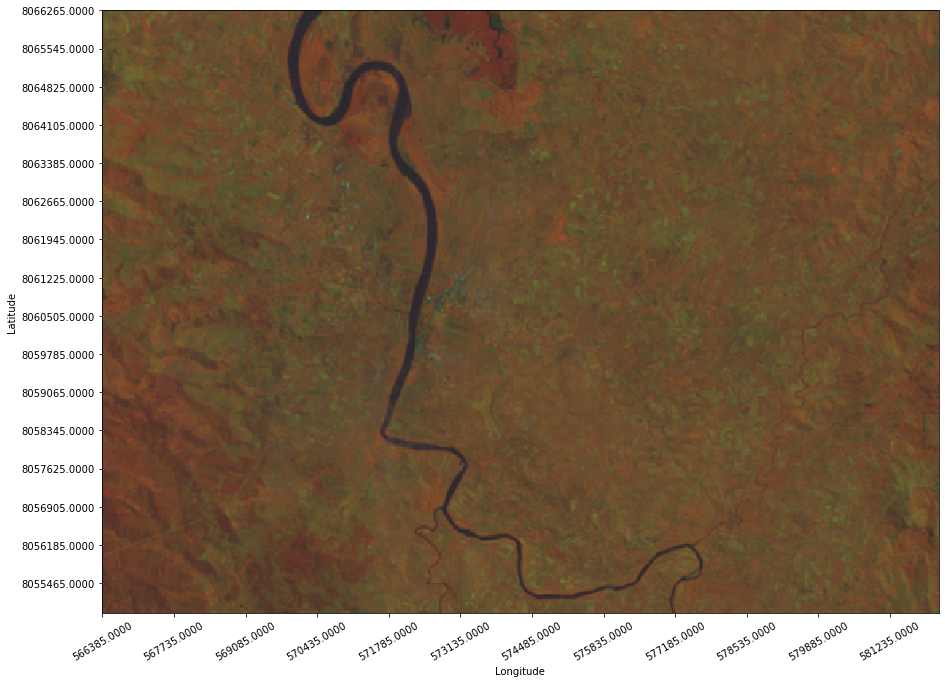

In [15]:
from datacube_utilities.dc_rgb import rgb
composite_t1 = composite_t1.rename({"y": "latitude", "x":"longitude"})
rgb(composite_t1, bands = ["nir","swir1","blue"], width = 15)
#plt.title('Year {}'.format(first_year))
plt.show()

> ### Last Year
> False Color Composite [nir, swir1, blue]

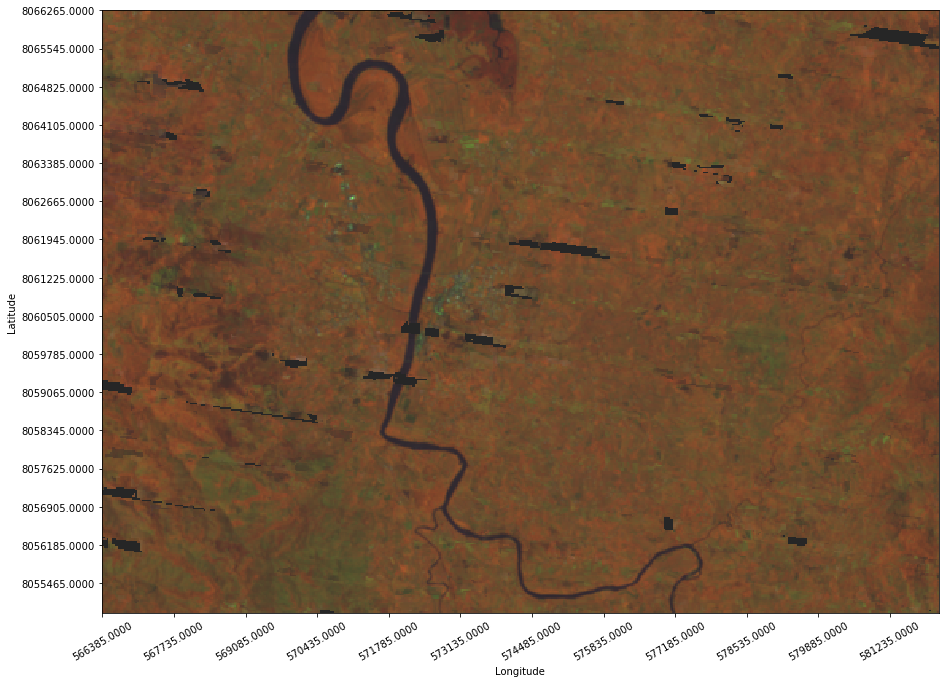

In [16]:
composite_t2 = composite_t2.rename({"y": "latitude", "x":"longitude"})

rgb(composite_t2, bands = ["nir","swir1","blue"], width = 15)
#plt.title('Year {}'.format(last_year))
plt.show()

## <a id="filter_survey_region"></a>Filter Out Everything Except the Survey Region [&#9652;](#top)

In [17]:
import rasterio.features
from datacube.utils import geometry
import xarray as xr

#def generate_mask(loaded_dataset:xr.Dataset,
#                  geo_polygon: datacube.utils.geometry ):
    
#    return rasterio.features.geometry_mask(
#                                [geo_polygon],
#                                out_shape = loaded_dataset.geobox.shape,
#                                transform = loaded_dataset.geobox.affine,
#                                all_touched = False,
#                                invert = True)

In [46]:
import numpy as np
import numpy.ma as ma
test = xr.Dataset.to_array(dataset_t1)
mx = ma.masked_array(test, mask=[-9999])


In [18]:
mask = dataset_t1.where(dataset_t1 != np.nan)

In [19]:
print(mask)

<xarray.Dataset>
Dimensions:   (time: 18, x: 526, y: 379)
Coordinates:
  * time      (time) datetime64[ns] 2000-02-02 2000-02-27 ... 2000-11-09
  * y         (y) float64 8.066e+06 8.066e+06 8.066e+06 ... 8.055e+06 8.055e+06
  * x         (x) float64 5.664e+05 5.664e+05 5.664e+05 ... 5.821e+05 5.821e+05
Data variables:
    red       (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    green     (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    nir       (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    swir1     (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    swir2     (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    pixel_qa  (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    blue      (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
Attributes:
    crs:      EPSG:32760


In [20]:
#mask = generate_mask(dataset_t1, disjoint_areas)

In [21]:
#filtered_composite_t1 = composite_t1.where(mask)
#filtered_composite_t2 = composite_t2.where(mask)

> ### **First Year Survey Region**
> False Color Composite [nir, swir1, blue]

In [22]:
#rgb(filtered_composite_t1, bands = ["nir","swir1","blue"],width = 15)
#plt.show()

> ### **Last Year Survey Region**
> False Color Composite [nir, swir1, blue]

In [23]:
#rgb(filtered_composite_t2, bands = ["nir","swir1","blue"],width = 15)
#plt.show()

## <a id="urban_extent"></a>Determine Urban Extent [&#9652;](#top)

> ### Urbanization Index Option 1: NDBI  
> The Normalized Difference Built-up Index (NDBI) is quick to calculate, but is sometimes inaccurate (e.g. in very arid regions).

In [24]:
def NDBI(dataset):
    return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

> ### Urbanization Index Option 2: Fractional Cover Bare Soil
> The fractional cover bare soil index is very slow to calculate in its current implementation, but is often more accurate than NDBI.

In [25]:
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify

**Choose the Urbanization Index to Use**

In [63]:
# Can be 'NDBI' or 'Fractional Cover'.
urbanization_index = 'NDBI'

In [64]:
urban_index_func = None
urban_index_range = None
if urbanization_index == 'NDBI':
    urban_index_func = NDBI
    urban_index_range = [-1, 1]
if urbanization_index == 'Fractional Cover Bare Soil':
    urban_index_func = lambda dataset: frac_coverage_classify(dataset).bs
    urban_index_range = [0, 100]    
plot_kwargs = dict(vmin=urban_index_range[0], vmax=urban_index_range[1])

> ### **First Year Urban Composite**

In [65]:
urban_composite_t1 = urban_index_func(composite_t1)

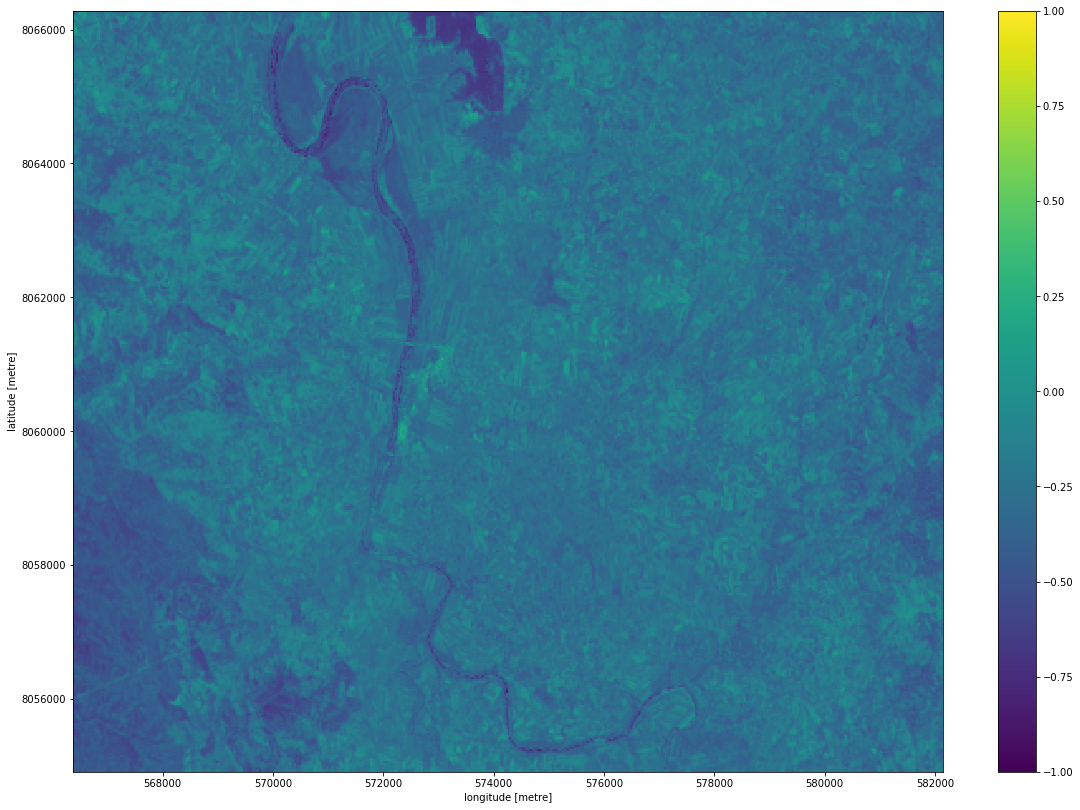

In [66]:
plt.figure(figsize = (19.5, 14))
urban_composite_t1.plot(**plot_kwargs)
plt.show()

> ### **Last Year Urban Composite**

In [67]:
urban_composite_t2 = urban_index_func(composite_t2)

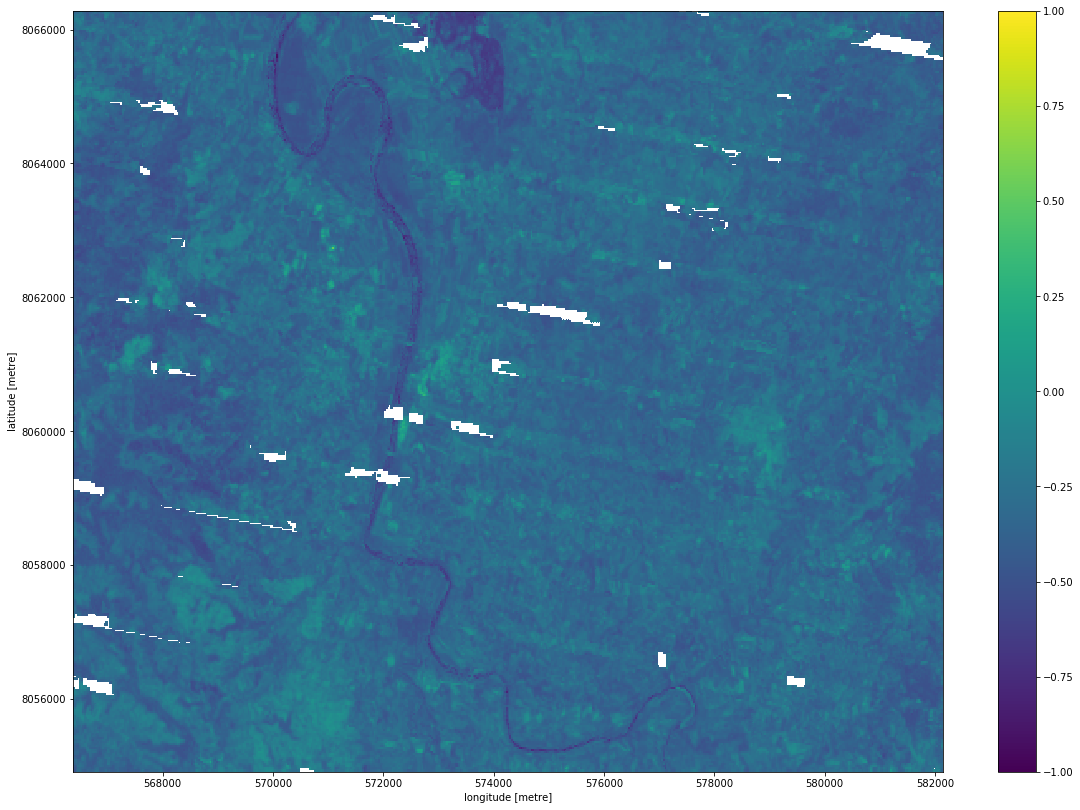

In [68]:
plt.figure(figsize = (19.5, 14))
urban_composite_t2.plot(**plot_kwargs)
plt.show()

> ### Defining Binary Urbanization

In [69]:
def urbanizaton(urban_index: xr.Dataset, urbanization_index) -> xr.DataArray:
    bounds = None
    if urbanization_index == 'NDBI':
        bounds = (0,0.3)
    if urbanization_index == 'Fractional Cover Bare Soil':
        bounds = (25, 100)
    
    urban = np.logical_and(urban_index > min(bounds), urban_index < max(bounds))
    
    is_clean = np.isfinite(urban_index)
    urban = urban.where(is_clean)
    
    return urban

In [70]:
import numpy as np

In [71]:
urban_product_t1 = urbanizaton(urban_composite_t1, urbanization_index)
urban_product_t2 = urbanizaton(urban_composite_t2, urbanization_index)

In [72]:
print(urban_product_t1)

<xarray.DataArray (latitude: 379, longitude: 526)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * latitude   (latitude) float64 8.066e+06 8.066e+06 ... 8.055e+06 8.055e+06
  * longitude  (longitude) float64 5.664e+05 5.664e+05 ... 5.821e+05 5.821e+05


In [73]:
print(composite_t1)

<xarray.Dataset>
Dimensions:    (latitude: 379, longitude: 526)
Coordinates:
  * latitude   (latitude) float64 8.066e+06 8.066e+06 ... 8.055e+06 8.055e+06
  * longitude  (longitude) float64 5.664e+05 5.664e+05 ... 5.821e+05 5.821e+05
Data variables:
    red        (latitude, longitude) int16 315 382 524 603 ... 622 743 747 747
    green      (latitude, longitude) int16 380 465 621 676 ... 683 736 831 678
    nir        (latitude, longitude) int16 3192 3224 3280 ... 2688 2972 3178
    swir1      (latitude, longitude) int16 1402 1592 1819 ... 2511 2342 2078
    swir2      (latitude, longitude) int16 480 633 710 926 ... 1352 1179 1060
    pixel_qa   (latitude, longitude) uint16 66 66 66 66 66 66 ... 66 66 66 66 66
    blue       (latitude, longitude) int16 257 272 350 451 ... 353 445 445 421


In [74]:
#test2 = composite_t1.red.values
#test = xr.Dataset.to_array(composite_t1.red, dim='red')
#print(test)

> ### First Year
> Urbanization product overlayed on false color composite 

In [75]:
import numpy as np
rgb(composite_t1, 
           bands = ["nir","swir1","blue"], 
           paint_on_mask = [(np.logical_and(urban_product_t1.astype(bool), mx), [255,0,0], width = 15)]
plt.show()

SyntaxError: invalid syntax (<ipython-input-75-d2e58f0625bc>, line 4)

In [76]:
print(composite_t1)

<xarray.Dataset>
Dimensions:    (latitude: 379, longitude: 526)
Coordinates:
  * latitude   (latitude) float64 8.066e+06 8.066e+06 ... 8.055e+06 8.055e+06
  * longitude  (longitude) float64 5.664e+05 5.664e+05 ... 5.821e+05 5.821e+05
Data variables:
    red        (latitude, longitude) int16 315 382 524 603 ... 622 743 747 747
    green      (latitude, longitude) int16 380 465 621 676 ... 683 736 831 678
    nir        (latitude, longitude) int16 3192 3224 3280 ... 2688 2972 3178
    swir1      (latitude, longitude) int16 1402 1592 1819 ... 2511 2342 2078
    swir2      (latitude, longitude) int16 480 633 710 926 ... 1352 1179 1060
    pixel_qa   (latitude, longitude) uint16 66 66 66 66 66 66 ... 66 66 66 66 66
    blue       (latitude, longitude) int16 257 272 350 451 ... 353 445 445 421


In [77]:
print('still going')

still going


> ### Last Year
> Urbanization Product overlayed on false color composite 

In [78]:
rgb(filtered_composite_t2,
    bands = ["nir","swir1","blue"],
    paint_on_mask = [(np.logical_and(urban_product_t2.astype(bool), mask),[255,0,0])],
    width = 15)
plt.show()

NameError: name 'filtered_composite_t2' is not defined

> ### Urbanization Change

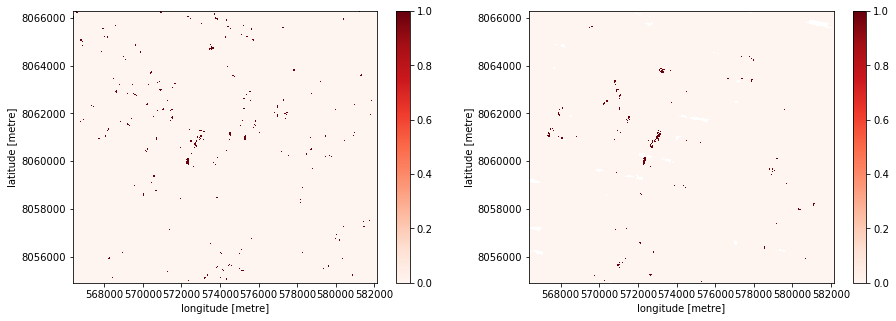

In [79]:
fig = plt.figure(figsize = (15,5))

#T1 (LEFT)
ax1 = fig.add_subplot(121)
urban_product_t1.plot(cmap = "Reds")
#ax1.set_title("Urbanization Extent {}".format(first_year))

#T2 (RIGHT)
ax2 = fig.add_subplot(122)
urban_product_t2.plot(cmap = "Reds")
#ax2.set_title("Urbanization Extent {}".format(last_year))

plt.show()

In [61]:
urbanized_area_t1 = float(  urban_product_t1.sum()  )
urbanized_area_t2 = float(  urban_product_t2.sum()  )

In [80]:
def land_consumption_rate(area_t1 = None, area_t2 = None, y = None):
#     return np.log(area_t2 / area_t1)/y
    return 10**(np.log10(area_t2/area_t1)/y) - 1

In [81]:
consumption_rate = land_consumption_rate(area_t1 = urbanized_area_t1, area_t2 = urbanized_area_t2, y = 10)

In [82]:
print("Land Consumption Rate of the Survey Region: {:.2%}".format(consumption_rate))

Land Consumption Rate of the Survey Region: -3.12%


## <a id="indicator"></a>SDG Indicator 11.3.1 [&#9652;](#top)

In [ ]:
print("The UN SDG 11.3.1 Indicator value (ratio of land consumption rate to population growth rate) "\
      "for this survey region is {:.2%}.".format(sdg_11_3_1(consumption_rate,pop_growth)))